In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from ForwardContracts import *

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 8192  # number of trajectories (batch size)
N = 100 # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [21] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2*10**4
lr = 1e-3

In [54]:
model.load_model("models/Forward1D.pth")

In [55]:
graph = model.iteration, model.training_loss

In [191]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 9.957e-01, Y0: 0.358, Time: 0.01, Learning Rate: 1.000e-03
It: 100, Loss: 1.264e-03, Y0: -0.011, Time: 0.52, Learning Rate: 1.000e-03
It: 200, Loss: 6.580e-03, Y0: -0.013, Time: 0.51, Learning Rate: 1.000e-03
It: 300, Loss: 1.769e-03, Y0: -0.004, Time: 0.52, Learning Rate: 1.000e-03
It: 400, Loss: 2.133e-04, Y0: -0.000, Time: 0.54, Learning Rate: 1.000e-03
It: 500, Loss: 9.085e-04, Y0: 0.001, Time: 0.53, Learning Rate: 1.000e-03
It: 600, Loss: 4.732e-04, Y0: 0.000, Time: 0.52, Learning Rate: 1.000e-03
It: 700, Loss: 3.392e-03, Y0: 0.004, Time: 0.53, Learning Rate: 1.000e-03
It: 800, Loss: 4.471e-04, Y0: 0.005, Time: 0.53, Learning Rate: 1.000e-03
It: 900, Loss: 3.431e-04, Y0: 0.006, Time: 0.52, Learning Rate: 1.000e-03
It: 1000, Loss: 6.265e-05, Y0: 0.002, Time: 0.52, Learning Rate: 1.000e-03
It: 1100, Loss: 1.797e-04, Y0: -0.003, Time: 0.53, Learning Rate: 1.000e-03
It: 1200, Loss: 1.190e-05, Y0: -0.001, Time: 0.55, Learning Rate: 1.000e-03
It: 1300, Loss: 4.477e-0

In [56]:
np.random.seed(37)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Text(0.5, 1.0, 'Evolution of the training loss')

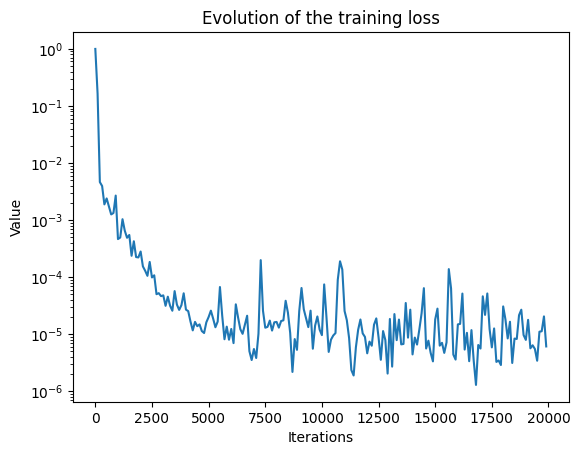

In [57]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

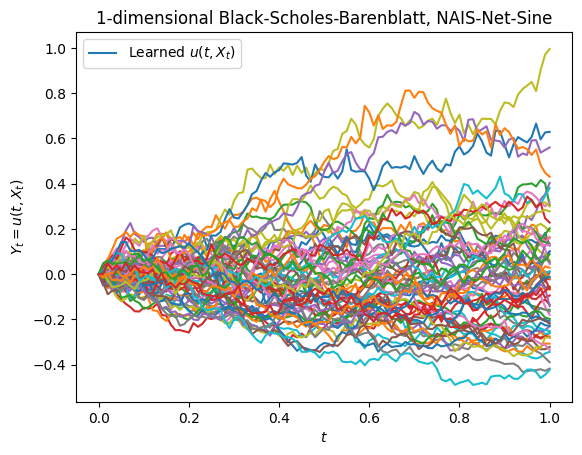

In [58]:
samples = 64

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')


plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

In [59]:
X_preds = np.sum(X_pred, axis=2) - 1
X_preds.shape

(8192, 101)

In [60]:
Y_preds = Y_pred.reshape(8192,101) * 100

In [61]:
time_stamps = t_test[0].reshape(101,)
time_stamps

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ], dtype=float32)

In [62]:
epe = np.mean(np.maximum(Y_preds,0),axis=0)    
epe

array([0.       , 0.9811211, 1.3880054, 1.7549142, 2.0091279, 2.2356029,
       2.469712 , 2.665853 , 2.8526547, 3.0163474, 3.1533418, 3.2977026,
       3.429713 , 3.5616152, 3.675008 , 3.8016107, 3.9513931, 4.036531 ,
       4.151067 , 4.274723 , 4.3680577, 4.49     , 4.6062813, 4.7035522,
       4.8076296, 4.914635 , 4.9728503, 5.054799 , 5.1949124, 5.2797875,
       5.353816 , 5.456918 , 5.5676837, 5.6701546, 5.7669873, 5.788572 ,
       5.8724117, 5.9693933, 6.0661936, 6.1461806, 6.2525864, 6.3501573,
       6.4205117, 6.4622827, 6.5604353, 6.649771 , 6.7389736, 6.834588 ,
       6.8933315, 6.9543195, 7.0591116, 7.124843 , 7.201854 , 7.2660623,
       7.350227 , 7.4194403, 7.448649 , 7.5374236, 7.616836 , 7.700377 ,
       7.786989 , 7.8444967, 7.895978 , 7.971677 , 8.0385   , 8.105102 ,
       8.173121 , 8.228791 , 8.31308  , 8.399598 , 8.415106 , 8.448482 ,
       8.486779 , 8.519899 , 8.591262 , 8.647048 , 8.6834545, 8.752751 ,
       8.808481 , 8.844951 , 8.918063 , 8.95911  , 

In [63]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([-5.3485539e-03, -9.7734380e-01, -1.3850697e+00, -1.6924887e+00,
       -1.9530323e+00, -2.2103324e+00, -2.4283185e+00, -2.6255639e+00,
       -2.7782979e+00, -2.9423165e+00, -3.0909126e+00, -3.2790570e+00,
       -3.4249430e+00, -3.5554180e+00, -3.6884420e+00, -3.8353193e+00,
       -4.0040445e+00, -4.1192446e+00, -4.2387333e+00, -4.3305011e+00,
       -4.4670515e+00, -4.5533824e+00, -4.6755919e+00, -4.7768908e+00,
       -4.8791013e+00, -4.9750857e+00, -5.0905604e+00, -5.1797409e+00,
       -5.2868447e+00, -5.3988647e+00, -5.5024500e+00, -5.5931878e+00,
       -5.6921954e+00, -5.7829738e+00, -5.8606081e+00, -5.9532866e+00,
       -6.0280542e+00, -6.1129284e+00, -6.1976666e+00, -6.2938342e+00,
       -6.3713875e+00, -6.4462729e+00, -6.5537367e+00, -6.6319795e+00,
       -6.7022567e+00, -6.7920127e+00, -6.8482418e+00, -6.9272375e+00,
       -7.0136361e+00, -7.0727048e+00, -7.1581979e+00, -7.2115946e+00,
       -7.2822213e+00, -7.3553314e+00, -7.4355054e+00, -7.5033879e+00,
      

In [64]:
from scipy.stats import norm

In [65]:
rv = norm()

In [66]:
x_init = 100.0
strike = 100.0
sigma = 0.25
r = 0.0

In [67]:
d1 = np.array([(-r * s + np.log(x_init/strike) + (r+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamps[1:]])
d2 = np.array([d1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamps[1:])])

In [68]:
epe_exact = x_init*rv.cdf(d1) - strike*np.exp(-r)*rv.cdf(d2)
epe_exact

array([0.99732974, 1.41040042, 1.72733577, 1.99450367, 2.22986477,
       2.44263083, 2.63827414, 2.82036016, 2.9913661 , 3.15309449,
       3.30690729, 3.45386207, 3.59479994, 3.73040328, 3.86123378,
       3.98776123, 4.1103832 , 4.22943928, 4.34522268, 4.45798825,
       4.56795962, 4.67533427, 4.78028647, 4.88297295, 4.98353381,
       5.08209484, 5.17877057, 5.2736645 , 5.36687122, 5.45847759,
       5.54856214, 5.63719745, 5.72445253, 5.81038808, 5.8950624 ,
       5.97852905, 6.06083741, 6.14203448, 6.22216431, 6.30126676,
       6.37938051, 6.45654068, 6.53278237, 6.60813654, 6.68263293,
       6.75630131, 6.82916668, 6.90125522, 6.97259134, 7.04319765,
       7.11309618, 7.18230658, 7.25084968, 7.31874452, 7.38600777,
       7.45265671, 7.518708  , 7.58417771, 7.64908013, 7.71343014,
       7.77724086, 7.84052537, 7.90329677, 7.96556757, 8.02734849,
       8.08865144, 8.14948653, 8.20986509, 8.26979605, 8.32929012,
       8.38835565, 8.44700275, 8.50523918, 8.56307327, 8.62051

In [69]:
ene_exact = x_init*rv.cdf(-d1) - strike*np.exp(-0)*rv.cdf(-d2) 
ene_exact

array([-0.99732974, -1.41040042, -1.72733577, -1.99450367, -2.22986477,
       -2.44263083, -2.63827414, -2.82036016, -2.9913661 , -3.15309449,
       -3.30690729, -3.45386207, -3.59479994, -3.73040328, -3.86123378,
       -3.98776123, -4.1103832 , -4.22943928, -4.34522268, -4.45798825,
       -4.56795962, -4.67533427, -4.78028647, -4.88297295, -4.98353381,
       -5.08209484, -5.17877057, -5.2736645 , -5.36687122, -5.45847759,
       -5.54856214, -5.63719745, -5.72445253, -5.81038808, -5.8950624 ,
       -5.97852905, -6.06083741, -6.14203448, -6.22216431, -6.30126676,
       -6.37938051, -6.45654068, -6.53278237, -6.60813654, -6.68263293,
       -6.75630131, -6.82916668, -6.90125522, -6.97259134, -7.04319765,
       -7.11309618, -7.18230658, -7.25084968, -7.31874452, -7.38600777,
       -7.45265671, -7.518708  , -7.58417771, -7.64908013, -7.71343014,
       -7.77724086, -7.84052537, -7.90329677, -7.96556757, -8.02734849,
       -8.08865144, -8.14948653, -8.20986509, -8.26979605, -8.32

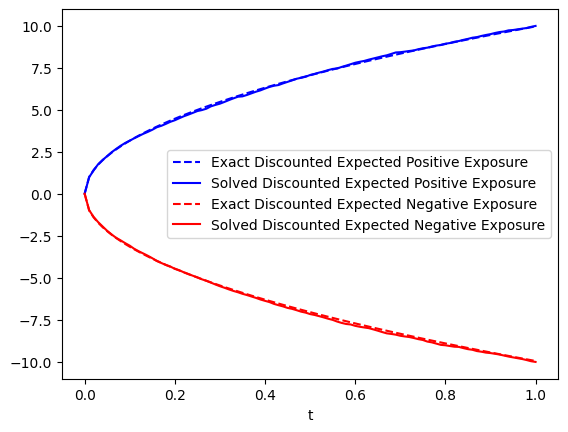

In [70]:
    fig = plt.figure()
    plt.plot(time_stamps,[0.0]+list(epe_exact),'b--',label='Exact Discounted Expected Positive Exposure')
    plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )

    plt.plot(time_stamps,[0.0]+list(ene_exact),'r--',label='Exact Discounted Expected Negative Exposure')
    plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')

    plt.xlabel('t')
    plt.legend()

    plt.show()

In [204]:
model.save_model("models/Forward1D.pth")